In [1]:
import os
import json
import math

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from matplotlib import ticker
from keras import layers, optimizers
from keras import Model
from keras.applications import DenseNet121
import random
# from keras.applications import VGG19
# from keras.applications.resnet50 import preprocess_input

from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from keras.models import Sequential

from imgaug import augmenters as iaa
from keras.utils import Sequence
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

print(os.listdir('../input'))

Using TensorFlow backend.


['aptos-crossvalidated-models-densenet', 'aptos2019-blindness-detection']


In [2]:
def rotateAndScale(img, scaleFactor = 0.5, degreesCCW = 30):
    (oldY,oldX) = img.shape[0],img.shape[1] #note: numpy uses (y,x) convention but most OpenCV functions use (x,y)
    M = cv2.getRotationMatrix2D(center=(oldX/2,oldY/2), angle=degreesCCW, scale=scaleFactor) #rotate about center of image.

    newX,newY = oldX*scaleFactor,oldY*scaleFactor
    
    r = np.deg2rad(degreesCCW)
    newX,newY = (abs(np.sin(r)*newY) + abs(np.cos(r)*newX),abs(np.sin(r)*newX) + abs(np.cos(r)*newY))

    (tx,ty) = ((newX-oldX)/2,(newY-oldY)/2)
    M[0,2] += tx #third column of matrix holds translation, which takes effect after rotation.
    M[1,2] += ty

    rotatedImg = cv2.warpAffine(img, M, dsize=(int(newX),int(newY)))
    return rotatedImg

def create_model(weights_path):
    inp = layers.Input(shape=(None, None, 3), name='image_input')
    base_model = DenseNet121(include_top=False,
                             weights=None,input_tensor=inp)

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(2048,activation='relu')(x) 
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(2048,activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(5, activation='softmax', name='predictions')(x)

    model = Model(inputs=inp, outputs=x)
    model.load_weights(weights_path, by_name=True)
    
    return model

In [3]:
list_model_dir = os.listdir("../input/aptos-crossvalidated-models-densenet/")
list_models = [file for file in os.listdir("../input/aptos-crossvalidated-models-densenet/") if file.endswith("h5")]
cross_valid_steps = len(list_models)

image_size = 224

In [4]:
path_test_img = "../input/aptos2019-blindness-detection/test_images"
path_test_excel = "../input/aptos2019-blindness-detection/sample_submission.csv"

df_test = pd.read_csv(path_test_excel)
df_test["diagnosis"] = np.random.randint(5, size=df_test.shape[0])

scores_predicted = np.empty([cross_valid_steps,len(df_test),5])
for step in range(cross_valid_steps):
    model_weight = '../input/aptos-crossvalidated-models-densenet/model_fold_{}.h5'.format(step)
    model = create_model(model_weight)
    print(model_weight)
    for i, name in enumerate(df_test['id_code']):
        path = os.path.join('../input/aptos2019-blindness-detection/test_images/', name+'.png')
        
        image = cv2.imread(path)
        image = rotateAndScale(image, scaleFactor = 0.5, degreesCCW = 0)
        image = cv2.resize(image, (image_size,image_size))
        image = cv2.addWeighted(image,4,cv2.GaussianBlur(image,(0,0) ,10) ,-4,128)

        score_predict = model.predict((image[np.newaxis])/255)
        scores_predicted[step,i,:] = score_predict
#         label_predict = np.argmax(score_predict)
#         predicted.append(str(label_predict))
        if i%200 == 0:
            print('Numer added: {}/{}'.format(i,df_test['id_code'].size))

../input/aptos-crossvalidated-models-densenet/model_fold_0.h5
Numer added: 0/1928
Numer added: 200/1928
Numer added: 400/1928
Numer added: 600/1928
Numer added: 800/1928
Numer added: 1000/1928
Numer added: 1200/1928
Numer added: 1400/1928
Numer added: 1600/1928
Numer added: 1800/1928
../input/aptos-crossvalidated-models-densenet/model_fold_1.h5
Numer added: 0/1928
Numer added: 200/1928
Numer added: 400/1928
Numer added: 600/1928
Numer added: 800/1928
Numer added: 1000/1928
Numer added: 1200/1928
Numer added: 1400/1928
Numer added: 1600/1928
Numer added: 1800/1928
../input/aptos-crossvalidated-models-densenet/model_fold_2.h5
Numer added: 0/1928
Numer added: 200/1928
Numer added: 400/1928
Numer added: 600/1928
Numer added: 800/1928
Numer added: 1000/1928
Numer added: 1200/1928
Numer added: 1400/1928
Numer added: 1600/1928
Numer added: 1800/1928
../input/aptos-crossvalidated-models-densenet/model_fold_3.h5
Numer added: 0/1928
Numer added: 200/1928
Numer added: 400/1928
Numer added: 600/19

In [5]:
predicted = np.argmax(scores_predicted.mean(axis=0),axis=1)
df_test['diagnosis'] = predicted
df_test.to_csv('submission.csv',index=False)

df_test["diagnosis"].describe()

count    1928.000000
mean        1.691909
std         0.977960
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: diagnosis, dtype: float64

../input/aptos2019-blindness-detection/test_images/0005cfc8afb6.png
../input/aptos2019-blindness-detection/test_images/003f0afdcd15.png
../input/aptos2019-blindness-detection/test_images/006efc72b638.png
../input/aptos2019-blindness-detection/test_images/00836aaacf06.png
../input/aptos2019-blindness-detection/test_images/009245722fa4.png
../input/aptos2019-blindness-detection/test_images/009c019a7309.png
../input/aptos2019-blindness-detection/test_images/010d915e229a.png


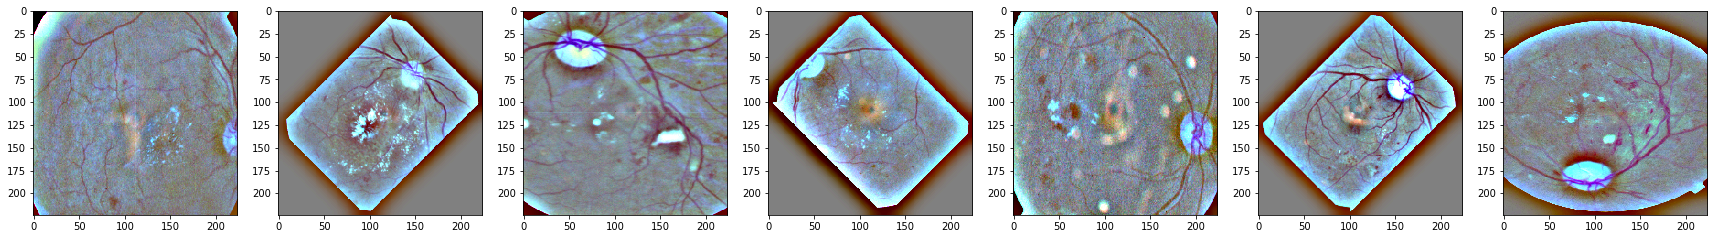

In [6]:
fig,ax = plt.subplots(1,7,figsize=(30,10))
for i, name in enumerate(df_test['id_code'].iloc[0:7]):
        path = os.path.join('../input/aptos2019-blindness-detection/test_images/', name+'.png')
        print(path)
        
        image = cv2.imread(path)
        image = rotateAndScale(image, scaleFactor = 0.5, degreesCCW = i*45)
        image = cv2.resize(image, (image_size,image_size))
        image = cv2.addWeighted(image,4,cv2.GaussianBlur(image,(0,0) ,10) ,-4,128)
        ax[i].imshow(image)

In [7]:
df_test.head()

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


In [8]:
scores_predicted

array([[[1.86155015e-03, 2.27818847e-01, 6.20343089e-01, 3.95675041e-02,
         1.10409021e-01],
        [8.99235602e-07, 1.25747596e-04, 1.81852117e-01, 7.59846091e-01,
         5.81751503e-02],
        [7.53610630e-06, 2.12212000e-03, 6.43800914e-01, 2.65769422e-01,
         8.83000121e-02],
        ...,
        [4.72701743e-07, 9.41981038e-04, 6.67753458e-01, 2.94953883e-01,
         3.63501981e-02],
        [1.02829035e-05, 2.30941296e-04, 1.28231555e-01, 6.46518111e-01,
         2.25009128e-01],
        [5.68951573e-03, 1.83589906e-01, 6.85202956e-01, 3.04708350e-02,
         9.50468034e-02]],

       [[1.94609240e-02, 1.79903939e-01, 6.41409516e-01, 4.14652191e-02,
         1.17760278e-01],
        [1.10666070e-03, 5.68235293e-03, 3.06646496e-01, 5.16531765e-01,
         1.70032710e-01],
        [1.62993430e-03, 6.73728902e-03, 5.18970609e-01, 3.41542900e-01,
         1.31119251e-01],
        ...,
        [3.55352735e-04, 4.98313038e-03, 4.74085957e-01, 4.12987262e-01,
        